Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


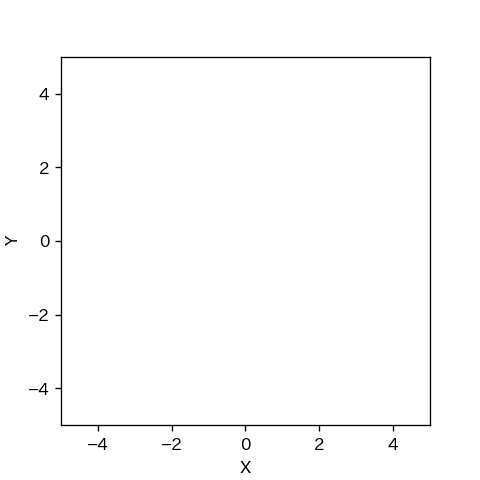

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        nearest_obs = np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id = observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p, self.map.landmarks[landmark_id].pos, *values)
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

In [3]:
def trial_kidnap(animation): ###mclkidnap1test
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
    
    world.draw()
    
    return(r.pose, pf.ml.pose)

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


<IPython.core.display.Javascript object>


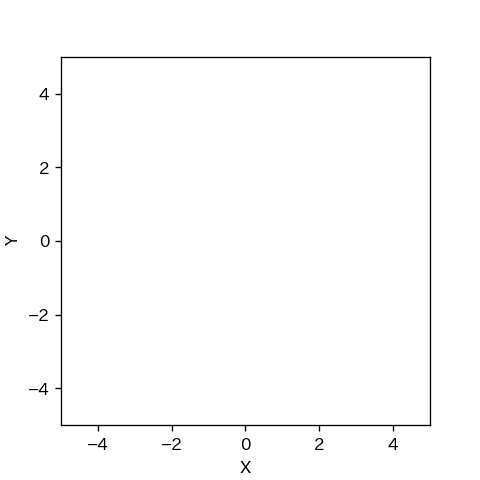

(array([ 1.66471224, -3.20275219,  0.59153655]),
 array([-2.5358932 , -1.69531007,  2.4332839 ]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

0 真値: [-0.63113693 -3.26325456  7.08705632] 推定値: [-2.67556154 -3.54257611  7.05223869] 誤差: 2.0634176730795355
1 真値: [-3.81847184 -2.16330203  9.04824622] 推定値: [-3.25740092 -2.14117923  2.76670345] 誤差: 0.5615068913033032
1
2 真値: [-2.07132164 -1.86110291  3.10329068] 推定値: [-2.14373827 -2.57366175  2.90586125] 誤差: 0.7162292026399003
2
3 真値: [-2.59532449 -3.82601848  6.0202242 ] 推定値: [-0.5665148  -6.14716488  0.36334942] 誤差: 3.082821661360456
4 真値: [0.72073408 3.06850204 6.7478692 ] 推定値: [0.50407985 3.47021574 6.5173282 ] 誤差: 0.4564131330826056
3
5 真値: [ 5.31337724 -3.86792558  2.57861492] 推定値: [ 5.45734464 -4.82106609  8.63345828] 誤差: 0.9639519899644573
4
6 真値: [ 4.07839162 -3.77822672  9.19951539] 推定値: [ 1.15851605 -0.97431274  5.1980879 ] 誤差: 4.048160934302117
7 真値: [-3.93167022 -0.92698843  3.83323344] 推定値: [-3.39421943  4.99166782  0.45800058] 誤差: 5.943008092737078
8 真値: [-3.56541238 -3.00650278  7.70330935] 推定値: [-3.02435478 -3.06281495  1.5166152 ] 誤差: 0.5439801332290981
5
9 真値: [2.

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


20 真値: [ 6.35457662 -2.99217689  2.82039211] 推定値: [ 3.54648564 -7.34589083  1.5153094 ] 誤差: 5.180752850358018
21 真値: [ 5.66709255 -2.10333437  7.68223426] 推定値: [ 5.75291308 -1.84715034  7.7677501 ] 誤差: 0.2701766493825653
11
22 真値: [1.1557553  0.25708984 2.96248765] 推定値: [1.46238283 0.7293029  3.12342588] 誤差: 0.5630325169637722
12
23 真値: [-5.18592457 -4.06599255  6.86743202] 推定値: [ 2.08484362 -0.49042627  1.39456558] 誤差: 8.102391270536007
24 真値: [3.62090207 0.00853729 3.01361264] 推定値: [0.92282513 4.9921059  0.43620173] 誤差: 5.6670605457741985
25 真値: [4.17089349 3.07077224 2.98362097] 推定値: [4.31874192 3.47567732 3.26175868] 誤差: 0.43105369788182296
13
26 真値: [-5.06054796  3.95470441  6.61080096] 推定値: [-2.3512441  -0.42502666  3.52674622] 誤差: 5.149987537564713
27 真値: [3.64425264 5.25965728 4.34555906] 推定値: [ 2.57463261  5.71843484 -1.54965708] 誤差: 1.1638573236829388
28 真値: [1.02004754 1.75370553 2.19643192] 推定値: [0.68086512 1.84957396 8.38945199] 誤差: 0.35247052218503366
14
29 真値: [ 5.977758